In [1]:
import os
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, f1_score, accuracy_score, roc_curve
from sklearn.metrics import precision_recall_curve
from scipy import stats

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

from hnet import AppendNet

def load_pretrained_model(pre_trained_loc="./PCLR.h5") :
    pre_trained_model = load_model(pre_trained_loc)
    
    return pre_trained_model

def do_bootstrap_regression(preds, trues, n=1000):
    rmse_list = []
    r_list = []
    pval_list = []

    rng = np.random.RandomState(seed=1)
    for _ in range(n):
        idxs = rng.choice(len(trues), size=len(trues), replace=True)
        pred_arr = preds[idxs]
        true_arr = trues[idxs]

        rmse = rmse_loss(pred_arr, true_arr)
        r, pval = stats.pearsonr(true_arr, pred_arr)

        rmse_list.append(rmse)
        r_list.append(r)
        pval_list.append(pval)

    return np.array(rmse_list), np.array(r_list), np.array(pval_list)

def confidence_interval(values, alpha=0.95):
    lower = np.percentile(values, (1-alpha)/2 * 100)
    upper = np.percentile(values, (alpha + (1-alpha)/2) * 100)
    return lower, upper

2023-04-09 00:20:18.004200: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 00:20:18.425615: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-09 00:20:19.370436: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/storage/araghu/.conda/envs/hfnet/lib/
2023-04-09 00:20:19.370583: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvi

In [4]:
def get_ecg(df):
    ecgs = []
    for idx in df.index:
        row = df.loc[idx]
        qid = row['QuantaID']
        doc = row['Date_of_Cath']
        fname = f'/storage/shared/apollo/same-day/{qid}_{doc}.csv'
        x = pd.read_csv(fname).values[...,1:].astype(np.float32)
        x /= 1000
        x = x[:4096, :].T
        ecgs.append(x)
        
    ecgs = np.array(ecgs)
    return np.transpose(ecgs, (0,2,1))

def get_data(batch_size=64):
    df_tab = pd.read_csv(os.path.join('/storage/shared/apollo/same-day/tabular_data.csv'))
    train_ids = np.load("./stores/train_ids.npy")
    val_ids = np.load("./stores/val_ids.npy")
    test_ids = np.load("./stores/test_ids.npy")

    train_ids = train_ids[len(train_ids) // 2 :]
    val_ids = val_ids[len(val_ids) // 2 :]
    test_ids = test_ids[len(test_ids) // 2 :]

    train_df = df_tab[df_tab["QuantaID"].isin(train_ids)]
    val_df = df_tab[df_tab["QuantaID"].isin(val_ids)]
    test_df = df_tab[df_tab["QuantaID"].isin(test_ids)]
    print(len(train_df), len(val_df), len(test_df))

    male_ids = np.load("./stores/test_female_ids.npy")
    female_ids = np.load("./stores/test_male_ids.npy")

    male_df = df_tab[df_tab["QuantaID"].isin(male_ids)]
    female_df = df_tab[df_tab["QuantaID"].isin(female_ids)]
    print(len(male_df), len(female_df))
        
    X_train = get_ecg(train_df)
    X_val = get_ecg(val_df)
    X_test = get_ecg(test_df)
    male_test = get_ecg(male_df)
    female_test = get_ecg(female_df)
    
    y_train = train_df["PCWP_mean"].values
    y_val = val_df["PCWP_mean"].values
    y_test = test_df["PCWP_mean"].values
    y_female = female_df["PCWP_mean"].values
    y_male = male_df["PCWP_mean"].values

    return X_train, y_train, X_val, y_val, X_test, y_test, male_test, y_male, female_test, y_female

def rmse_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"

pre_trained_model = load_pretrained_model(pre_trained_loc='./PCLR.h5')
latent = tf.keras.Model(pre_trained_model.inputs, pre_trained_model.get_layer('embed').output)
full_model = AppendNet(latent, new_layers = [128, 1], classification=False) # same hidden dimension as dml (128)

optimizer = tf.keras.optimizers.Adam() # can modify LR, of course
# loss_fn = tf.keras.losses.BinaryCrossentropy()
loss_fn = rmse_loss

X_train, y_train, X_val, y_val, X_test, y_test, male_test, y_male, female_test, y_female = get_data()

2442 893 923
1114 711


In [25]:
epochs = 50
full_model.compile(optimizer, loss_fn)
full_model.fit(X_train, y_train, epochs=epochs)

Epoch 1/50
77/77 [==============================] - 12s 99ms/step - loss: 15.0063
Epoch 2/50
77/77 [==============================] - 8s 103ms/step - loss: 13.9235
Epoch 3/50
77/77 [==============================] - 11s 147ms/step - loss: 13.7081
Epoch 4/50
77/77 [==============================] - 8s 103ms/step - loss: 13.2645
Epoch 5/50
77/77 [==============================] - 8s 102ms/step - loss: 13.6062
Epoch 6/50
77/77 [==============================] - 8s 103ms/step - loss: 13.4615
Epoch 7/50
77/77 [==============================] - 8s 104ms/step - loss: 13.6717
Epoch 8/50
77/77 [==============================] - 8s 103ms/step - loss: 13.6344
Epoch 9/50
77/77 [==============================] - 8s 99ms/step - loss: 13.0034
Epoch 10/50
77/77 [==============================] - 8s 99ms/step - loss: 13.3835
Epoch 11/50
77/77 [==============================] - 8s 100ms/step - loss: 13.4399
Epoch 12/50
77/77 [==============================] - 8s 100ms/step - loss: 13.2835
Epoch 13/50
77

In [46]:
epochs = 100
pre_trained_model = load_pretrained_model(pre_trained_loc='./PCLR.h5')
latent = tf.keras.Model(pre_trained_model.inputs, pre_trained_model.get_layer('embed').output)
full_model = AppendNet(latent, new_layers = [128, 1], classification=False)

optimizer = tf.keras.optimizers.Adam() # can modify LR, of course
# loss_fn = tf.keras.losses.BinaryCrossentropy()
loss_fn = rmse_loss
full_model.compile(optimizer, loss_fn)
full_model.fit(X_train, y_train, epochs=epochs)

Epoch 1/100
77/77 [==============================] - 12s 98ms/step - loss: 15.5466
Epoch 2/100
77/77 [==============================] - 8s 102ms/step - loss: 14.0876
Epoch 3/100
77/77 [==============================] - 8s 101ms/step - loss: 13.7544
Epoch 4/100
77/77 [==============================] - 8s 101ms/step - loss: 13.3075
Epoch 5/100
77/77 [==============================] - 8s 104ms/step - loss: 13.6482
Epoch 6/100
77/77 [==============================] - 8s 103ms/step - loss: 13.4675
Epoch 7/100
77/77 [==============================] - 8s 107ms/step - loss: 13.6814
Epoch 8/100
77/77 [==============================] - 8s 102ms/step - loss: 13.6239
Epoch 9/100
77/77 [==============================] - 8s 103ms/step - loss: 13.0276
Epoch 10/100
77/77 [==============================] - 12s 153ms/step - loss: 13.3434
Epoch 11/100
77/77 [==============================] - 8s 101ms/step - loss: 13.4667
Epoch 12/100
77/77 [==============================] - 8s 102ms/step - loss: 13.3233


In [6]:
epochs = 150
pre_trained_model = load_pretrained_model(pre_trained_loc='./PCLR.h5')
latent = tf.keras.Model(pre_trained_model.inputs, pre_trained_model.get_layer('embed').output)
full_model = AppendNet(latent, new_layers = [128, 1], classification=False)

optimizer = tf.keras.optimizers.Adam() # can modify LR, of course
loss_fn = rmse_loss
full_model.compile(optimizer, loss_fn)
full_model.fit(X_train, y_train, epochs=epochs)

Epoch 1/150


2023-04-09 00:42:14.698153: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-04-09 00:42:16.868245: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-09 00:42:16.870428: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-09 00:42:16.870504: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-04-09 00:42:16.873389: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-09 00:42:16.873946: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


77/77 [==============================] - 17s 86ms/step - loss: 15.2831
Epoch 2/150
77/77 [==============================] - 6s 78ms/step - loss: 13.9908
Epoch 3/150
77/77 [==============================] - 5s 68ms/step - loss: 13.7485
Epoch 4/150
77/77 [==============================] - 5s 70ms/step - loss: 13.3453
Epoch 5/150
77/77 [==============================] - 6s 72ms/step - loss: 13.6345
Epoch 6/150
77/77 [==============================] - 6s 72ms/step - loss: 13.4960
Epoch 7/150
77/77 [==============================] - 5s 70ms/step - loss: 13.6513
Epoch 8/150
77/77 [==============================] - 5s 70ms/step - loss: 13.6370
Epoch 9/150
77/77 [==============================] - 4s 51ms/step - loss: 13.0293
Epoch 10/150
77/77 [==============================] - 4s 51ms/step - loss: 13.3668
Epoch 11/150
77/77 [==============================] - 4s 48ms/step - loss: 13.4074
Epoch 12/150
77/77 [==============================] - 5s 69ms/step - loss: 13.2576
Epoch 13/150
77/77 [====

Epoch 100/150
77/77 [==============================] - 5s 68ms/step - loss: 12.9233
Epoch 101/150
77/77 [==============================] - 5s 69ms/step - loss: 12.8503
Epoch 102/150
77/77 [==============================] - 5s 71ms/step - loss: 12.6220
Epoch 103/150
77/77 [==============================] - 5s 71ms/step - loss: 12.9161
Epoch 104/150
77/77 [==============================] - 5s 70ms/step - loss: 12.8678
Epoch 105/150
77/77 [==============================] - 5s 70ms/step - loss: 13.0156
Epoch 106/150
77/77 [==============================] - 5s 69ms/step - loss: 12.4732
Epoch 107/150
77/77 [==============================] - 4s 50ms/step - loss: 12.7896
Epoch 108/150
77/77 [==============================] - 4s 49ms/step - loss: 12.6068
Epoch 109/150
77/77 [==============================] - 4s 49ms/step - loss: 12.8019
Epoch 110/150
77/77 [==============================] - 4s 49ms/step - loss: 12.7599
Epoch 111/150
77/77 [==============================] - 5s 69ms/step - loss: 

In [65]:
epochs = 175
pre_trained_model = load_pretrained_model(pre_trained_loc='./PCLR.h5')
latent = tf.keras.Model(pre_trained_model.inputs, pre_trained_model.get_layer('embed').output)
full_model = AppendNet(latent, new_layers = [128, 1], classification=False)

optimizer = tf.keras.optimizers.Adam() # can modify LR, of course
# loss_fn = tf.keras.losses.BinaryCrossentropy()
loss_fn = rmse_loss
full_model.compile(optimizer, loss_fn)
full_model.fit(X_train, y_train, epochs=epochs)

Epoch 1/175
77/77 [==============================] - 13s 94ms/step - loss: 16.1545
Epoch 2/175
77/77 [==============================] - 7s 96ms/step - loss: 14.0904
Epoch 3/175
77/77 [==============================] - 8s 98ms/step - loss: 13.7653
Epoch 4/175
77/77 [==============================] - 7s 94ms/step - loss: 13.3809
Epoch 5/175
77/77 [==============================] - 7s 95ms/step - loss: 13.6664
Epoch 6/175
77/77 [==============================] - 7s 96ms/step - loss: 13.5445
Epoch 7/175
77/77 [==============================] - 7s 96ms/step - loss: 13.6168
Epoch 8/175
77/77 [==============================] - 7s 95ms/step - loss: 13.7027
Epoch 9/175
77/77 [==============================] - 7s 96ms/step - loss: 12.9921
Epoch 10/175
77/77 [==============================] - 7s 95ms/step - loss: 13.2832
Epoch 11/175
77/77 [==============================] - 7s 93ms/step - loss: 13.4776
Epoch 12/175
77/77 [==============================] - 7s 95ms/step - loss: 13.3266
Epoch 13/175

In [62]:
epochs = 200
pre_trained_model = load_pretrained_model(pre_trained_loc='./PCLR.h5')
latent = tf.keras.Model(pre_trained_model.inputs, pre_trained_model.get_layer('embed').output)
full_model = AppendNet(latent, new_layers = [128, 1], classification=False)

optimizer = tf.keras.optimizers.Adam() # can modify LR, of course
# loss_fn = tf.keras.losses.BinaryCrossentropy()
loss_fn = rmse_loss
full_model.compile(optimizer, loss_fn)
full_model.fit(X_train, y_train, epochs=epochs)

Epoch 1/200
77/77 [==============================] - 12s 96ms/step - loss: 15.4870
Epoch 2/200
77/77 [==============================] - 8s 98ms/step - loss: 14.0569
Epoch 3/200
77/77 [==============================] - 8s 98ms/step - loss: 13.7952
Epoch 4/200
77/77 [==============================] - 7s 97ms/step - loss: 13.4087
Epoch 5/200
77/77 [==============================] - 7s 95ms/step - loss: 13.6161
Epoch 6/200
77/77 [==============================] - 7s 95ms/step - loss: 13.4954
Epoch 7/200
77/77 [==============================] - 7s 93ms/step - loss: 13.7052
Epoch 8/200
77/77 [==============================] - 7s 95ms/step - loss: 13.6811
Epoch 9/200
77/77 [==============================] - 10s 126ms/step - loss: 13.0129
Epoch 10/200
77/77 [==============================] - 8s 98ms/step - loss: 13.3911
Epoch 11/200
77/77 [==============================] - 7s 97ms/step - loss: 13.3794
Epoch 12/200
77/77 [==============================] - 7s 96ms/step - loss: 13.3289
Epoch 13/2

77/77 [==============================] - 7s 92ms/step - loss: 12.5300
Epoch 197/200
77/77 [==============================] - 7s 93ms/step - loss: 12.2884
Epoch 198/200
77/77 [==============================] - 7s 91ms/step - loss: 12.6437
Epoch 199/200
77/77 [==============================] - 7s 91ms/step - loss: 12.5554
Epoch 200/200
77/77 [==============================] - 7s 92ms/step - loss: 12.6519


In [7]:
'''
Getting prediction result from test set
'''
y_pred = full_model.predict(X_test)

29/29 [==============================] - 1s 22ms/step


In [50]:
full_model.save('./PCLR_finetuned_100epc.pb', save_format='tf')

INFO:tensorflow:Assets written to: ./PCLR_finetuned_100epc.pb/assets


INFO:tensorflow:Assets written to: ./PCLR_finetuned_100epc.pb/assets


In [ ]:
# Load saved tf model
loaded_model = tf.keras.models.load_model('./PCLR_finetuned.pb')

# Calculate Classification Performance

In [38]:
from scipy import stats
r, pval = stats.pearsonr(y_test, np.concatenate(y_pred))
print(rmse_loss(y_test, y_pred))
print(r, pval)

tf.Tensor(11.718298284532933, shape=(), dtype=float64)
0.5179734023757416 1.7000212654359237e-64


In [45]:
'''
50 epoch model
'''
rmse, r, pval = do_bootstrap_regression(np.concatenate(y_pred), y_test)
print(rmse.mean(), r.mean(), pval.mean())
print(confidence_interval(rmse), confidence_interval(r), confidence_interval(pval))

10.662241673856977 0.5168803322877793 3.885793744767385e-48
(10.168321327256356, 11.186809058909072) (0.46935757473184414, 0.5653645253170076) (4.403350490234938e-79, 9.551261205355765e-52)


In [49]:
'''
100 epoch model
'''
rmse, r, pval = do_bootstrap_regression(np.concatenate(y_pred), y_test)
print(rmse.mean(), r.mean(), pval.mean())
print(confidence_interval(rmse), confidence_interval(r), confidence_interval(pval))

10.08667670973824 0.5084383288648698 5.124600599466284e-44
(9.593113688193553, 10.608999002632787) (0.4534978599475333, 0.5592618550246696) (4.559193565980286e-77, 5.1785051956098e-48)


In [55]:
'''
150 epoch model
'''
rmse, r, pval = do_bootstrap_regression(np.concatenate(y_pred), y_test)
print(rmse.mean(), r.mean(), pval.mean())
print(confidence_interval(rmse), confidence_interval(r), confidence_interval(pval))

9.848489722993618 0.46944465590783035 3.0449579264607663e-35
(9.338509122190928, 10.366695124278358) (0.4179658931128352, 0.5250832141152932) (1.53915223843851e-66, 2.4962666858646983e-40)


In [67]:
'''
175 epoch model
'''
rmse, r, pval = do_bootstrap_regression(np.concatenate(y_pred), y_test)
print(rmse.mean(), r.mean(), pval.mean())
print(confidence_interval(rmse), confidence_interval(r), confidence_interval(pval))

9.850863609684545 0.49767297670143773 5.444660867408191e-43
(9.35858689961837, 10.36080203660364) (0.44836077927932255, 0.5494779474730525) (6.255070185093435e-74, 7.624212698991938e-47)


In [64]:
'''
200 epoch model
'''
rmse, r, pval = do_bootstrap_regression(np.concatenate(y_pred), y_test)
print(rmse.mean(), r.mean(), pval.mean())
print(confidence_interval(rmse), confidence_interval(r), confidence_interval(pval))

10.292663228474936 0.47730382296197216 2.970788508126865e-37
(9.783613390282376, 10.830710205153133) (0.42562339353459316, 0.5319061016216475) (1.5150117569838069e-68, 6.574814400434942e-42)


# Subgroup Performance

In [9]:
'''
150 epoch model
'''
y_pred = full_model.predict(X_test)
rmse, r, pval = do_bootstrap_regression(np.concatenate(y_pred), y_test)
print(rmse.mean(), r.mean(), pval.mean())
print(confidence_interval(rmse), confidence_interval(r), confidence_interval(pval))

29/29 [==============================] - 0s 15ms/step
10.039471949439573 0.484278478554083 4.902644094954473e-40
(9.525350752320579, 10.568466900038379) (0.43473973384124037, 0.5391527787121098) (9.961575265424734e-71, 7.704279890631517e-44)


In [10]:
male_pred = full_model.predict(male_test)
rmse_male, r_male, pval_male = do_bootstrap_regression(male_pred, y_male)
print(rmse_male.mean(), r_male.mean(), pval_male.mean())
print(confidence_interval(rmse_male), confidence_interval(r_male), confidence_interval(pval_male))

35/35 [==============================] - 1s 20ms/step
11.138536381121034 0.5375720048181512 2.588236043433157e-62
(10.667693263920379, 11.60368216416663) (0.49158370952901476, 0.5835548220252381) (1.2198080590473877e-102, 7.817113498207257e-69)


In [11]:
female_pred = full_model.predict(female_test)
rmse_female, r_female, pval_female = do_bootstrap_regression(female_pred, y_female)
print(rmse_female.mean(), r_female.mean(), pval_female.mean())
print(confidence_interval(rmse_female), confidence_interval(r_female), confidence_interval(pval_female))

23/23 [==============================] - 1s 48ms/step
11.632920180842552 0.4567063803872219 2.592465179744597e-24
(10.960079965417428, 12.304295703102092) (0.395897170005528, 0.516874417736068) (8.079708423410909e-50, 4.265781643675823e-28)


In [12]:
from scipy import stats

# Kruskal-Wallis test
kruskal_stat, kruskal_p_value = stats.kruskal(rmse_male, rmse_female)
print("Kruskal-Wallis test:")
print("  Statistic:", kruskal_stat)
print("  p-value:", kruskal_p_value)

# Independent t-test
t_stat, t_p_value = stats.ttest_ind(rmse_male, rmse_female)
print("\nIndependent t-test:")
print("  Statistic:", t_stat)
print("  p-value:", t_p_value)

Kruskal-Wallis test:
  Statistic: 854.8728237721143
  p-value: 6.341729505804985e-188

Independent t-test:
  Statistic: -36.85698456210658
  p-value: 2.45423091570506e-227


In [13]:
np.save('/storage/hyewonjeong/metricssl_02/result/pclr/rmse.npy', rmse)
np.save('/storage/hyewonjeong/metricssl_02/result/pclr/rmse_male.npy',rmse_male)
np.save('/storage/hyewonjeong/metricssl_02/result/pclr/rmse_female.npy',rmse_female)

# Trend Prediction

In [36]:
dir_root = '/storage/hyewonjeong/metricssl_02'
dir_result = '/storage/hyewonjeong/metricssl_02/result'
dir_trend = '/storage/hyewonjeong/metricssl_02/trend_fig'

df_tab = pd.read_csv('/storage/shared/apollo/same-day/tabular_data.csv')
trend_ids = np.load(os.path.join(dir_root, '/storage/hyewonjeong/metricssl_02/stores/trend_testid.npy'))

# Extract rows from tabular_data.csv that correspond to the trend IDs
trend_df = df_tab[df_tab["QuantaID"].isin(trend_ids)]

# Iterate over the trend IDs and plot the predicted and actual values of PCWP_mean
for trend_id in trend_ids:
    # Get rows from tabular_data.csv that correspond to the current trend ID
    trend_rows = trend_df[trend_df["QuantaID"] == trend_id]
    
    # Sort the rows by the catheterization date
    trend_rows = trend_rows.sort_values(by="Date_of_Cath")
    
    # Get the PCWP_mean values and catheterization dates
    pcwp_means = trend_rows["PCWP_mean"].values
    cath_dates = pd.to_datetime(trend_rows["Date_of_Cath"]).dt.date
    
    # Compute the predicted values of PCWP_mean using the supervised DML model
    features = trend_rows.drop(["QuantaID", "Date_of_Cath", "PCWP_mean"], axis=1).values
    ecgs = get_ecg(trend_rows)
    pclr_pred = full_model.predict(ecgs)
    np.save(os.path.join(dir_trend, 'pclr_{}'.format(str(trend_id))), pclr_pred)

1/1 [==============================] - 0s 37ms/step


In [37]:
example_pred = np.load('/storage/hyewonjeong/metricssl_02/trend_fig/pclr_1647084.npy')

In [38]:
example_pred

array([[7.0870132],
       [7.3210917],
       [6.219167 ],
       [5.883561 ],
       [5.8503976],
       [7.1804   ],
       [7.3934503],
       [8.690815 ],
       [7.4013486]], dtype=float32)

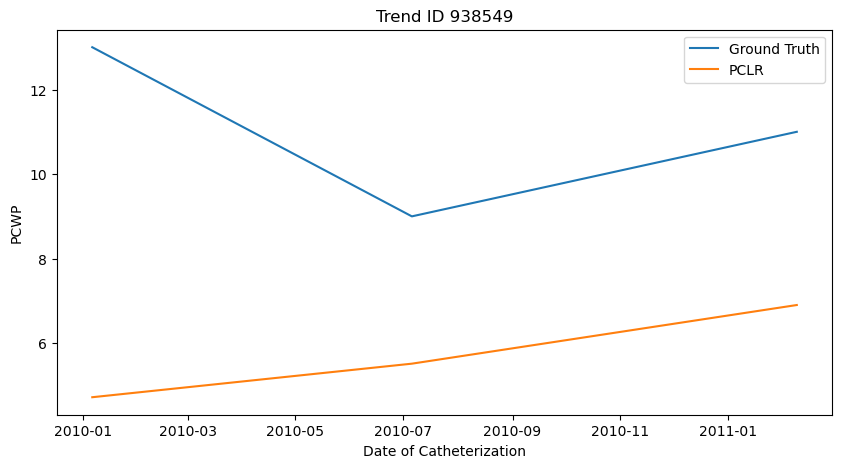

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the predicted and actual values of PCWP_mean
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(cath_dates, pcwp_means, label="Ground Truth")
ax.plot(cath_dates, pclr_pred, label="PCLR")
ax.set_xlabel("Date of Catheterization")
ax.set_ylabel("PCWP")
ax.set_title(f"Trend ID {trend_id}")
ax.legend()
plt.savefig(os.path.join(dir_trend, f"trend_{trend_id}.png"))